In [20]:
import matplotlib
import numpy as np
import heapq

from numpy.random import randint
import matplotlib.pyplot as plt

In [21]:
class Node:
    def __init__(self, key, v1, v2):
        self.key = key
        self.v1 = v1
        self.v2 = v2

    def __eq__(self, other):
        return np.sum(np.abs(self.key - other.key)) == 0

    def __ne__(self, other):
        return self.key != other.key

    def __lt__(self, other):
        return (self.v1, self.v2) < (other.v1, other.v2)

    def __le__(self, other):
        return (self.v1, self.v2) <= (other.v1, other.v2)

    def __gt__(self, other):
        return (self.v1, self.v2) > (other.v1, other.v2)

    def __ge__(self, other):
        return (self.v1, self.v2) >= (other.v1, other.v2)

In [40]:
class DStarLite: #The algorithm as it is
    def __init__(self, r_map, sx, sy, gx, gy):
        self.start = np.array([sx, sy])
        self.goal = np.array([gx, gy])
        self.k_m = 0
        self.rhs = np.ones((r_map.shape[0], r_map.shape[1])) * np.inf
        self.g = self.rhs.copy()
        self.graph = r_map
        self.sensed_map = np.zeros((r_map.shape[0], r_map.shape[1]))
        self.rhs[self.goal[0], self.goal[1]] = 0
        self.queue = []
        node = Node(self.goal, *self.CalculateKey(self.goal))
        heapq.heappush(self.queue, node)

    # heuristic estimation
    def h_estimate(self, s1, s2):
        x_dist = s1[0] - s2[0]
        y_dist = s1[1] - s2[1]
        dist = np.sqrt(x_dist ** 2 + y_dist ** 2)
        return dist

    def CalculateKey(self, s):
        key = [0, 0]
        key[0] = min(self.g[s[0], s[1]], self.rhs[s[0], s[1]]) + self.h_estimate(self.start, s) + self.k_m
        key[1] = min(self.g[s[0], s[1]], self.rhs[s[0], s[1]])
        return key



    def UpdateVertex(self, u):
        if np.sum(np.abs(u - self.goal)) != 0:
            s_list = self.succ(u)
            min_s = []
            for s in s_list:
                min_s.append(self.cost(u, s) + self.g[s[0], s[1]])
            self.rhs[u[0], u[1]] = min(min_s)
        if Node(u, 0, 0) in self.queue:
            self.queue.remove(Node(u, 0, 0))
            heapq.heapify(self.queue)
        if self.g[u[0], u[1]] != self.rhs[u[0], u[1]]:
            heapq.heappush(self.queue, Node(u, *self.CalculateKey(u)))

    def ComputeShortestPath(self):
        while len(self.queue) > 0 and \
                heapq.nsmallest(1, self.queue)[0] < Node(self.start, *self.CalculateKey(self.start)) or \
                self.rhs[self.start[0], self.start[1]] != self.g[self.start[0], self.start[1]]:

            k_old = heapq.nsmallest(1, self.queue)[0]
            print(k_old)
            u = heapq.heappop(self.queue).key
            if k_old < Node(u, *self.CalculateKey(u)):
                heapq.heappush(self.queue, Node(u, *self.CalculateKey(u)))
            elif self.g[u[0], u[1]] > self.rhs[u[0], u[1]]:
                self.g[u[0], u[1]] = self.rhs[u[0], u[1]]
                s_list = self.succ(u)
                for s in s_list:
                    self.UpdateVertex(s)
            else:
                self.g[u[0], u[1]] = np.inf
                s_list = self.succ(u)
                s_list.append(u)
                for s in s_list:
                    self.UpdateVertex(s)

    # fetch successors and predessors but in our case both are same
    def succ(self, u):
        s_list = [np.array([u[0] - 1, u[1] - 1]), np.array([u[0] - 1, u[1]]), np.array([u[0] - 1, u[1] + 1]),
                  np.array([u[0], u[1] - 1]), np.array([u[0], u[1] + 1]), np.array([u[0] + 1, u[1] - 1]),
                  np.array([u[0] + 1, u[1]]), np.array([u[0] + 1, u[1] + 1])]
        row = self.graph.shape[0]
        col = self.graph.shape[1]
        real_list = []
        for s in s_list:
            if 0 <= s[0] < row and 0 <= s[1] < col:
                real_list.append(s)
        return real_list

    # calculate cost between nodes
    def cost(self, u1, u2):
        if self.sensed_map[u1[0], u1[1]] == np.inf or self.sensed_map[u2[0], u2[1]] == np.inf:
            return np.inf
        else:
            return self.h_estimate(u1, u2)

    def sense(self, range_s):
        real_list = []
        row = self.graph.shape[0]
        col = self.graph.shape[1]
        for i in range(-range_s, range_s + 1):
            for j in range(-range_s, range_s + 1):
                if 0 <= self.start[0] + i < row and 0 <= self.start[1] + j < col:
                    if not (i == 0 and j == 0):
                        real_list.append(np.array([self.start[0] + i, self.start[1] + j]))
        return real_list

In [46]:
def ScanAndUpdate(present, last):
    s_list = present.sense(3)
    flag = False
    for s in s_list:
        if present.sensed_map[s[0], s[1]] != present.graph[s[0], s[1]]:
            flag = True
            # print('See a wall!')
            break
    if flag:
        present.k_m += present.h_estimate(last, present.start)
        last = present.start.copy()
        for s in s_list:
            if present.sensed_map[s[0], s[1]] != present.graph[s[0], s[1]]:
#                 plt.plot(s[0], s[1], 'xr')
                present.sensed_map[s[0], s[1]] = present.graph[s[0], s[1]]
                present.UpdateVertex(s)
        for i in range(len(present.queue)):
            u = heapq.heappop(present.queue).key
            temp = Node(u, *present.CalculateKey(u))
            heapq.heappush(present.queue, temp)
        # heapq.heapify(present.queue)
        present.ComputeShortestPath()
    return last

<IPython.core.display.Javascript object>


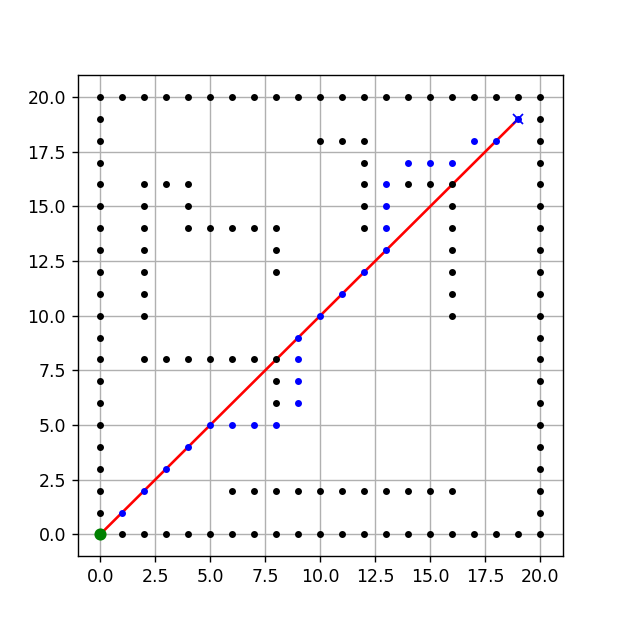

Goal Reached


In [48]:
if __name__ == "__main__":
#     set start and goal point
    sx = 0
    sy = 0
    gx = 19
    gy = 19

#     set obstable positions
    graph = np.array([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

    ox, oy = [], []
    for i in range(0, len(graph)):
        for j in range(0, len(graph[i])):
            if graph[i][j] == 1:
                ox.append(i)
                oy.append(j)

    graph[graph == 1] = np.inf
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.grid(True)
    ax.plot([sx, gx], [sy, gy], 'r')
    ax.plot(ox, oy, ".k")
    ax.plot(sx, sy, "og")
    ax.plot(gx, gy, "xb")

#     Starting of Main()
    last = np.array([sx, sy])
    dstar = DStarLite(graph, sx, sy, gx, gy)
    dstar.ComputeShortestPath()
    while np.sum(np.abs(dstar.start - dstar.goal)) != 0:
        s_list = dstar.succ(dstar.start)
        min_s = np.inf
        for s in s_list:
#             plt.plot(s[0], s[1], 'xy')
            if dstar.cost(dstar.start, s) + dstar.g[s[0], s[1]] < min_s:
                min_s = dstar.cost(dstar.start, s) + dstar.g[s[0], s[1]]
                temp = s
        dstar.start = temp.copy()
#         print(dstar.start[0], dstar.start[1])
        ax.plot(dstar.start[0], dstar.start[1], '.b')
        fig.canvas.draw()
        last = ScanAndUpdate(dstar, last)
        plt.pause(0.1)
    print("Goal Reached")

    plt.show()